In [48]:
spark.stop()

# Setting paths

In [1]:
import os, sys
import datetime as dt
DEVEL_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel")
if DEVEL_SRC not in sys.path:
    sys.path.append(DEVEL_SRC)

USECASES_SRC = os.path.join(DEVEL_SRC, "use-cases") # TODO when - is removed, remove also this line and adapt imports
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)
    
AMDOCS_SRC = os.path.join(DEVEL_SRC, "amdocs_informational_dataset") # TODO when - is removed, remove also this line and adapt imports
if AMDOCS_SRC not in sys.path: 
    sys.path.append(AMDOCS_SRC)
    
import pykhaos.utils.custom_logger as clogger
logging_file = os.path.join(os.environ.get('BDA_USER_HOME', ''), "logging",
                                    "out_" + dt.datetime.now().strftime("%Y%m%d_%H%M%S") + ".log")
logger = clogger.configure_logger(log_filename=logging_file, std_channel=sys.stderr, logger_name="")
logger.info("Logging to file {}".format(logging_file))    
    
EXTERNAL_PATH = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel", "pykhaos", "external_lib")
if EXTERNAL_PATH not in sys.path:
    sys.path.append(EXTERNAL_PATH)

    
    
import pykhaos.utils.notebooks as nb


RUNNING_FROM_NOTEBOOK = nb.isnotebook()
import matplotlib.pyplot as plt
if RUNNING_FROM_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline  
    
    
    
#logger = my_project.logger

if not RUNNING_FROM_NOTEBOOK:
    args = my_project.arg_parser()

20190313-114926 [INFO ] Logging to file /var/SP/data/home/csanc109/logging/out_20190313_114926.log
20190313-114926 [DEBUG] $HOME=/home/csanc109
20190313-114926 [DEBUG] matplotlib data path /opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/matplotlib/mpl-data
20190313-114926 [DEBUG] loaded rc file /opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc
20190313-114926 [DEBUG] matplotlib version 2.2.3
20190313-114926 [DEBUG] interactive is False
20190313-114926 [DEBUG] platform is linux2
20190313-114926 [DEBUG] loaded modules: ['_multiprocessing', 'IPython.core.error', 'ipython_genutils.py3compat', 'traitlets.config.sys', 'concurrent.futures.types', 'ipykernel.parentpoller', 'traitlets.config.decorator', 'ctypes.os', 'pexpect.select', 'runpy', 'gc', 'numpy.lib.numpy', 'pty', 'prompt_toolkit.terminal.vt100_output', 'prompt_toolkit.key_binding.six', 'dateutil.parser.dateutil', 'pygments.filters', 'IPython.utils.pprint', 'numpy.core.i

20190313-114926 [DEBUG] CACHEDIR=/home/csanc109/.cache/matplotlib
20190313-114926 [DEBUG] Using fontManager instance from /home/csanc109/.cache/matplotlib/fontList.json
20190313-114926 [DEBUG] backend module://ipykernel.pylab.backend_inline version unknown
20190313-114926 [DEBUG] backend module://ipykernel.pylab.backend_inline version unknown
20190313-114926 [DEBUG] backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
import time
start_time = time.time()
app_name = "CCC-DP"

import pykhaos.utils.pyspark_configuration as pyspark_config
sc, spark, sql_context = pyspark_config.get_spark_session(app_name=app_name, log_level="OFF", min_n_executors = 1, max_n_executors = 10, n_cores = 4,
                         executor_memory = "16g", driver_memory="4g")
print("Ended spark session: {} secs | default parallelism={}".format(time.time() - start_time,
                                                                     sc.defaultParallelism))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Ended spark session: 26.6688129902 secs | default parallelism=4


In [3]:
from amdocs_informational_dataset.engine.call_centre_calls import CallCentreCalls
from pyspark.sql.functions import collect_set, concat, size, coalesce, col, lpad, struct, count as sql_count, lit, min as sql_min, max as sql_max, collect_list, udf, when, desc, asc, to_date, create_map, sum as sql_sum
from pyspark.sql.types import StringType, ArrayType, MapType, StructType, StructField, IntegerType
from pyspark.sql.functions import array, regexp_extract
from itertools import chain

In [52]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline 
# from churn.config_manager.ccc_model_config_mgr import CCCmodelConfig
# import time

20190313-090524 [DEBUG] backend module://ipykernel.pylab.backend_inline version unknown


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
"CAT1_MODE" in df_car.columns

In [ ]:
cols = df_car.columns


fx_cols = [col_ for col_ in df_car.columns if
               ("fx_" in col_.lower() or "fecha" in col_.lower() or "date" in col_.lower()) and not ("days_since" in col_ or "days_until" in col_)]
imputed_avg = [col_ for col_ in df_car.columns if col_.endswith("imputed_avg")]
pcg_redem = [col_ for col_ in df_car.columns if col_.startswith("pcg_redem_")]
orders = [col_ for col_ in df_car.columns if col_.lower().startswith("order") and (col_.lower().endswith("id") or
                                                                                   col_.lower().endswith("date") or
                                                                                   col_.lower().endswith("description"))]
hour_max = [col_ for col_ in df_car.columns if col_.startswith("GNV_hour")]

bucket_cols = [col_ for col_ in df_car.columns if col_.lower().startswith("bucket") or col_.lower().startswith("ccc_bucket") or col_.lower().startswith("ccc_raw") or col_.lower().startswith("raw")]

proxy_cols = ["TOTAL_COMERCIAL", "TOTAL_NO_COMERCIAL", "COMERCIAL", "NO_COMERCIAL", "PRECIO", "TERMINAL", "CONTENIDOS", "SERVICIO/ATENCION",
                  "TECNICO", "BILLING", "FRAUD", "NO_PROB", "CAT1_MODE", "CAT2_MODE"]

# remove penalties of descriptions
novalen_penal_cols = [col_ for col_ in df_car.columns if col_.lower().startswith("penal_") and (col_.lower().endswith("desc_promo") or
                                                                                                col_.lower().endswith("desc_penal"))]
useless =  ['bucket_list', 'bucket_set', 'cat1_list', 'cat2_list', "DIR_LINEA1", "DIR_LINEA2", "DIR_LINEA3", "DIR_LINEA4", "DIR_FACTURA1",
            "DIR_FACTURA2", "DIR_FACTURA3", "DIR_FACTURA4", "num_cliente_car", "num_cliente", "NOMBRE", "PRIM_APELLIDO", "SEG_APELLIDO", "NOM_COMPLETO",
            'bucket_list', 'bucket_set', 'TRAT_FACT', 'NOMBRE_CLI_FACT', 'APELLIDO1_CLI_FACT',
            'APELLIDO2_CLI_FACT', 'NIF_CLIENTE', 'CTA_CORREO_CONTACTO', 'CTA_CORREO', 'codigo_postal_city']


quedan = list(set(cols) - set(pcg_redem + fx_cols + imputed_avg + useless + novalen_penal_cols + orders + hour_max + bucket_cols + proxy_cols))
len(quedan)

In [ ]:
df_metadata = spark.read.option("delimiter", "|").option("header", True).csv("/data/udf/vf_es/churn/metadata")


In [ ]:
print(df_customer.count(), df_customer.dropDuplicates(["num_cliente"]).count())


In [ ]:
#df_customer.groupby("PUBLICIDAD").agg(sql_count("*").alias("count")).sort(desc("count")).show(100,False)

df_customer.where(col("max_days_until_penal_cust_pending_end_date") != col("total_max_days_until_penal_cust_pending_end_date")).select("penal_cust_pending_n1_penal_amount", 
                                                                                                                                       "days_until_penal_cust_pending_n1_end_date", 
                                                                                                                                       "max_days_until_penal_cust_pending_end_date", 
                                                                                                                                       "total_max_days_until_penal_cust_pending_end_date").show(100,False)

In [ ]:
df_inci = spark.read.option("delimiter", "|").option("header", True).csv("/data/udf/vf_es/churn/ccc_model/comercial/df_c20181007_c20181107_n60_comercial_msisdn/")
#df_inci.where(col("IND_PBMA_SRV")==0).groupby("IND_PBMA_SRV", "DETALLE_PBMA_SRV").agg(count("*").alias("count")).show(1000, False)
"CAT1_MODE" in df_inci.columns

In [ ]:
starting_day = "20181114"
closing_day = "20190114"

from pykhaos.utils.date_functions import move_date_n_cycles

ss = starting_day
while ss <= closing_day:
    print(ss)
    ss = move_date_n_cycles(ss,1)



In [ ]:
df.select([count(when(isNull(c), 1)).alias(c) for c in ["FECHA_MIGRACION"]])

In [ ]:
# cols_comerciales = [col for col in ccc_id_grouped.columns
#                 if (col.startswith('sum_CCC_Pagar_menos') or
#                     col.startswith('sum_CCC_Ofrecimiento') or
#                     col.startswith('sum_CCC_Precios') or
#                     col.startswith('sum_CCC_Factura') or
#                     col.startswith('sum_CCC_Productos')
#                    )]
# cols_servicio = [col for col in ccc_id_grouped.columns
#                 if (col.startswith('sum_CCC_Incidencia') or
#                     col.startswith('sum_CCC_Averia') or
#                     col.startswith('sum_CCC_Consulta_Tecnica') or
#                     col.startswith('sum_CCC_Provision') or
#                     col.startswith('sum_CCC_Resultado_Escalo') or
#                     col.startswith('sum_CCC_Resultado_Envio_tecnico') or
#                     col.startswith('sum_CCC_Resultado_Transferencia') or
#                     col.startswith('sum_CCC_Resultado_Reclamacion')
#                    )]

# cols_servicio_fibra = [col for col in ccc_id_grouped.columns
#                       if (col.startswith('sum_CCC_Incidencia_Provision_Fibra') or
#                           col.startswith('sum_CCC_Averia_Fibra') or
#                           col.startswith('sum_CCC_Consulta_Tecnica_Fibra') or
#                           col.startswith('sum_CCC_Provision_Fibra')
#                          )]
# cols_servicio_neba = [col for col in ccc_id_grouped.columns
#                       if (col.startswith('sum_CCC_Incidencia_Provision_Neba') or
#                           col.startswith('sum_CCC_Averia_Neba') or
#                           col.startswith('sum_CCC_Consulta_Tecnica_Neba') or
#                           col.startswith('sum_CCC_Provision_Neba')
#                          )]
# cols_servicio_dsl = [col for col in ccc_id_grouped.columns
#                     if (col.startswith('sum_CCC_Incidencia_Provision_DSL') or
#                         col.startswith('sum_CCC_Averia_DSL') or
#                         col.startswith('sum_CCC_Consulta_Tecnica_DSL') or
#                         col.startswith('sum_CCC_Provision_DSL')
#                        )]
# cols_servicio_movil = [col for col in ccc_id_grouped.columns
#                       if (col.startswith('sum_CCC_Incidencia_Provision_Movil') or
#                           col.startswith('sum_CCC_Averia_Movil') or
#                           col.startswith('sum_CCC_Consulta_Tecnica_Movil') or
#                           col.startswith('sum_CCC_Provision_Movil')
#                          )]
# cols_servicio_tv = [col for col in ccc_id_grouped.columns
#                       if (col.startswith('sum_CCC_Incidencia_Provision_TV') or
#                           col.startswith('sum_CCC_Averia_TV') or
#                           col.startswith('sum_CCC_Consulta_Tecnica_TV') or
#                           col.startswith('sum_CCC_Provision_TV')
#                          )]
# cols_servicio_modemrouter = [col for col in ccc_id_grouped.columns
#                       if (col.startswith('sum_CCC_Incidencia_Provision_Modem/Router') or
#                           col.startswith('sum_CCC_Averia_Modem/Router') or
#                           col.startswith('sum_CCC_Consulta_Tecnica_Modem/Router') or
#                           col.startswith('sum_CCC_Provision_Modem/Router')
#                          )]

In [ ]:
df_all = df_all.withColumn("is_fraud", when(col("INT_RAZON").rlike("(?i)enga.o comercial|venta enga.osa"),1).otherwise(0))
df_all = df_all.withColumn("Queja_Trato", when(col("INT_SUBTIPO").isin(["Queja trato", "Quejas sevicios de atencion"]),1).otherwise(0))

In [ ]:
CAT_PRECIO = "PRECIO"
CAT_TERMINAL = "TERMINAL"
CAT_CONTENIDOS = "CONTENIDOS"
CAT_COMERCIAL = "COMERCIAL"
CAT_NO_COMERCIAL = "NO_COMERCIAL"
CAT_SERV_ATENCION = "SERVICIO/ATENCION"
CAT_TECNICO = "TECNICO"
CAT_BILLING = "BILLING"
CAT_FRAUD = "FRAUD"
CAT_FACTURA = "FACTURA"
NO_PROB = "NO_PROB"

# ADD CATEGORIES TO CALLS

df_all = df_all.withColumn("CATEGORY_2", \
                           # - - - - - - - - - PRECIO
                                        when(col('INT_TIPO').rlike("(?i)cliente quiere pagar menos|clte quiere pagar menos|ofrecimiento comercial|precios y promociones|plan de precios|planes de precios") , CAT_PRECIO)
                           # - - - - - - - - - SERVICIO/ATENCION
                                        .when(col("INT_SUBTIPO").isin(["Queja trato", "Quejas sevicios de atencion"]),CAT_SERV_ATENCION)
                           # - - - - - - - - - CONTENIDOS
                                        .when(col("INT_TIPO").rlike("(?i)productos"), CAT_CONTENIDOS)
                           # - - - - - - - - - ENGAÑO
                                        .when(col("INT_RAZON").rlike("(?i)enga.o comercial|venta enga.osa"), CAT_FRAUD)
                           # - - - - - - - - - TECNICO
                                         .when(col('INT_TIPO').rlike('(?i)^Averia'),CAT_TECNICO)
                                         .when((col('INT_TIPO').rlike('(?i)^Transferencia'))& (col("INT_SUBTIPO").rlike('(?i)^Aver.as')), CAT_TECNICO)
                                         .when(col('INT_TIPO').rlike('(?i)^Inc Provis.*Neba|^Inc Provision Fibra|^Inc Provision DSL|^Incidencia%ecnica|^Incidencia%SGI|^Inc|^Incidencia'),CAT_TECNICO)
                                         .when(col('INT_TIPO').rlike('(?i)^Consulta tec'),CAT_TECNICO)
                                         .when(col("Raw_Resultado").rlike("Raw_Resultado_Escalo|Raw_Resultado_Envio_tecnico|Raw_Resultado_Transferencia|Raw_Resultado_Reclamacion"), CAT_TECNICO) 
                           # - - - - - - - - - FACTURA                 
                                         .when(col('INT_TIPO').rlike('(?i)factura'), CAT_FACTURA)
                           # - - - - - - - - - TERMINAL                 
                                       .when(col("INT_TIPO")=="TERMINAL", "TERMINAL")
                           # - - - - - - - - - NO_PROB :)                 
                                       .when((col("INT_TIPO")=="INFORMACION")| ((col("INT_TIPO")=="TRANSFERENCIA") & (col("Bucket")=="Other customer information management")), NO_PROB).otherwise("NA")
    )# end
                  
    
df_all = (df_all.withColumn("CATEGORY_1", when(col('CATEGORY_2').isin([CAT_PRECIO, CAT_TERMINAL, CAT_CONTENIDOS]), CAT_COMERCIAL)
                           .when(col('CATEGORY_2').isin([CAT_SERV_ATENCION, CAT_TECNICO, CAT_BILLING, CAT_FRAUD]), CAT_NO_COMERCIAL)
                           .otherwise(col('CATEGORY_2'))))
   
#df_all.where(col("CATEGORY_1")=="NA").select("CATEGORY_2", "INT_Tipo").groupBy("CATEGORY_2", "INT_Tipo").agg(sql_count("*").alias("count")).sort(desc("count")).show()


# FALTA
# col('Raw_Productos') hay que desglosarlo



In [ ]:
df_all.where(col("CATEGORY_1")=="NA").select("INT_Tipo", "INT_Tipo").groupBy("INT_Tipo", "INT_Tipo").agg(sql_count("*").alias("count")).sort(desc("count")).show(30, False)

In [ ]:
from pyspark.sql.functions import desc
df_all.where(col("CATEGORY_1")=="NA").select("INT_Tipo", "INT_Tipo","INT_Resultado").groupBy("INT_Tipo", "INT_Tipo","INT_Resultado").agg(sql_count("*").alias("count")).sort(desc("count")).show(30, False)

In [ ]:


from reportlab.lib.enums import TA_RIGHT


In [ ]:
import argparse
import csv
import re
import subprocess
import sys
import time
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, concat, concat_ws, date_format, dayofmonth, format_string, from_unixtime, length, \
	lit, lower, lpad, month, regexp_replace, translate, udf, unix_timestamp, year, when, upper, collect_set, collect_list, \
    count as sql_count, min as sql_min, max as sql_max, struct, size, coalesce, sum as sql_sum
from pyspark.sql.types import DateType, IntegerType, StringType, StructField, StructType
from pyspark.sql.utils import AnalysisException
from engine.general_functions import format_date, compute_diff_days, sum_horizontal
from collections import Counter
from pyspark.sql.types import StringType


def add_l2_ccc_variables(df_all, df_pivot, process_date):

    print("Calling to add_l2_ccc_variables....")

    df_agg = (df_all
              .withColumn("fx_interaction",
                          concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0')))
              .withColumn("tuples", struct(["fx_interaction", "Bucket"]))
              .groupby('msisdn')
              .agg(sql_count(lit(1)).alias("num_interactions"),
                   sql_min(col('fx_interaction')).alias("first_interaction"),
                   sql_max(col('fx_interaction')).alias("latest_interaction"),
                   sql_max(col("tuples")).alias("tuples_max"),  # latest interaction: [max(fx_interaction), bucket]
                   sql_min(col("tuples")).alias("tuples_min"),  # first interaction: [min(fx_interaction), bucket]
                   collect_list('Bucket').alias("bucket_list"),
                   collect_set('Bucket').alias("bucket_set"),
                   sql_sum("Bucket_NA").alias("num_NA_buckets"),
                   sql_sum("IVR").alias("num_ivr_interactions"),
                   collect_list('CATEGORY_1').alias("cat1_list"),
                   collect_list('CATEGORY_2').alias("cat2_list"),
            ))

    df_agg = df_agg.withColumn("ref_date", format_date(lit(process_date)))
    df_agg = (df_agg.withColumn("bucket_1st_interaction", col("tuples_min")["Bucket"])
              .withColumn("bucket_latest_interaction", col("tuples_max")["Bucket"])
              .withColumn("nb_diff_buckets", size("bucket_set"))
              .drop(*['tuples_max', 'tuples_min'])
              )

    for cc in ["first_interaction", "latest_interaction"]:
        df_agg = (df_agg.withColumn("fx_{}".format(cc),
                                    format_date(cc, filter_dates_1900=True))  # days before 1900 converted to None
                  .withColumn("days_since_{}".format(cc), compute_diff_days("fx_{}".format(cc), "ref_date")))

    df_agg = df_agg.drop("ref_date")

    def get_mode_problems(lst):
        # filter NA y NO_PROB
        if not lst: return None
        lst=[ll for ll in lst if ll and ll!=NO_PROB]
        dd = Counter(lst).most_common(2)
        return dd[0][0] 
    get_mode_udf = udf(lambda lst: get_mode(lst), StringType())

    df_agg = (df_agg.withColumn("CAT1_MODE", when(coalesce(size(col("cat1_list")), lit(0)) == 0, "None").otherwise(get_mode_udf(col("cat1_list"))))
              .withColumn("CAT2_MODE", when(coalesce(size(col("cat1_list")), lit(0)) == 0, "None").otherwise(get_mode_udf(col("cat2_list"))))
                    .withColumnRenamed("msisdn", "msisdn_agg"))

    df_pivot = df_pivot.join(df_agg, on=df_pivot["msisdn"]==df_agg["msisdn_agg"], how="left")
    df_pivot = df_pivot.drop(*["msisdn_agg"])
    return df_pivot


df_agg = add_l2_ccc_variables(df_all, df_ccc, ccc_end_model)





In [ ]:
df_agg.select("CAT1_MODE").groupBy("CAT1_MODE").agg(sql_count("*").alias("count")).sort(desc("count")).show(30, False)

In [ ]:
df_agg.select("CAT2_MODE").groupBy("CAT2_MODE").agg(sql_count("*").alias("count")).sort(desc("count")).show(30, False)

In [ ]:
df_scores_incidencias.select(*['msisdn', 'comb_score', 'comb_decile', 'IND_PBMA_SRV', 'DETALLE_PBMA_SRV']).write.mode('overwrite').format('csv').option('sep', '|').option('header', 'true').save('/tmp/csanc109/churn/preds_comb_20181107_all_incidences.csv.20181122_vtipis1')

In [ ]:
#df_all.select("Raw_Resultado").distinct().show(20,False)
# +---------------------------+
# |Raw_Resultado              |
# +---------------------------+
# |Raw_Resultado_Bajas        |
# |Raw_Resultado_Retenido     |
# |Raw_Resultado_Informacion  |
# |null                       |
# |Raw_Resultado_Envio_tecnico|
# |Raw_Resultado_Escalo       |
# |Raw_Resultado_Reclamacion  |
# |Raw_Resultado_Transferencia|
# |Raw_Resultado_Solucionado  |
# |Raw_Resultado_Abono        |
# |Raw_Resultado_No_Retenido  |
# +---------------------------+

# cols_servicio_fibra =[col_ for col_ in self.pivoted_by_msisdn.columns if re.match("^CCC_Incidencia_Provision_Fibra|^CCC_Averia_Fibra|^CCC_Consulta_Tecnica_Fibra|^CCC_Provision_Fibra", col_)]
# cols_servicio_neba =[col_ for col_ in self.pivoted_by_msisdn.columns if re.match("^CCC_Incidencia_Provision_Neba|^CCC_Averia_Neba|^CCC_Consulta_Tecnica_Neba|^sum_CCC_Provision_Neba", col_)]
# cols_servicio_dsl = [col_ for col_ in self.pivoted_by_msisdn.columns if re.match("^CCC_Incidencia_Provision_DSL|^CCC_Averia_DSL|^CCC_Consulta_Tecnica_DSL|^sum_CCC_Provision_DSL")]
# cols_servicio_movil = [col_ for col_ in self.pivoted_by_msisdn.columns if re.match("^CCC_Incidencia_Provision_Movil|^CCC_Averia_Movil|^CCC_Consulta_Tecnica_Movil|^CCC_Provision_Movil")]

# cols_servicio_tv = [col_ for col_ in self.pivoted_by_msisdn.columns if re.match("^CCC_Incidencia_Provision_TV|^CCC_Averia_TV|^CCC_Consulta_Tecnica_TV|^CCC_Provision_TV")]
# cols_servicio_modemrouter = [col_ for col_ in self.pivoted_by_msisdn.columns if re.match('^CCC_Incidencia_Provision_Modem/Router|^CCC_Averia_Modem/Router|^CCC_Consulta_Tecnica_Modem/Router|^CCC_Provision_Modem/Router')]
# cols_servicio_comerciales = [col_ for col_ in self.pivoted_by_msisdn.columns if re.match('^CCC_Pagar_menos|^CCC_Ofrecimiento|^CCC_Precios|^CCC_Factura|^CCC_Productos')]


# cols_servicio = [col_ for col_ in self.pivoted_by_msisdn.columns if re.match("^CCC_Incidencia|^CCC_Averia|^CCC_Consulta_Tecnica|^CCC_Provision|^CCC_Resultado_Escalo|^CCC_Resultado_Envio_tecnico|^CCC_Resultado_Transferencia|^CCC_Resultado_Reclamacion")]                                                                                               
# cols_precio = [col_ for col_ in self.pivoted_by_msisdn.columns if re.match('^CCC_Pagar_menos|^CCC_Ofrecimiento|^CCC_Precios|^CCC_Productos')]
# cols_billing = [col_ for col_ in self.pivoted_by_msisdn.columns if re.match('^CCC_Factura')]
# cols_tecnico = [col_ for col_ in self.pivoted_by_msisdn.columns if re.match("^CCC_Incidencia|^CCC_Averia|^CCC_Consulta_Tecnica|^CCC_Provision|^CCC_Resultado_Escalo|^CCC_Resultado_Envio_tecnico|^CCC_Resultado_Transferencia|^CCC_Resultado_Reclamacion")]                                                                                               

                                                                             
                                                                             
# self.pivoted_by_msisdn = (self.pivoted_by_msisdn.withColumn("servicio_fibra", sum_horizontal(cols_servicio_fibra))
#                                                 .withColumn("servicio_neba", sum_horizontal(cols_servicio_neba))
#                                                 .withColumn("servicio_dsl", sum_horizontal(cols_servicio_dsl))
#                                                 .withColumn("servicio_movil", sum_horizontal(cols_servicio_movil))
#                                                 .withColumn("servicio_tv", sum_horizontal(cols_servicio_tv))
#                                                 .withColumn("servicio_modemrouter", sum_horizontal(cols_servicio_modemrouter))
#                                                 .withColumn("servicio_comerciales", sum_horizontal(cols_servicio_comerciales))
#                                                 .withColumn("servicio", sum_horizontal(cols_servicio))
#                          )





In [ ]:
df_scores_incidencias.columns

In [ ]:

CLOSING_DAY = "20181231" 
from pykhaos.utils.date_functions import move_date_n_days, move_date_n_yearmonths
ccc_start_date_ = move_date_n_days(CLOSING_DAY, -30, str_fmt="%Y%m%d")



# # Use the previous YYYYMM to get the service problems
# yyyymm_str = move_date_n_yearmonths(CLOSING_DAY[:6], -1)
# print("Using yyyymm={} to obtain the service_problems".format(yyyymm_str))

# from churn.datapreparation.general.problemas_servicio_data_loader import get_service_problems

# df_service_problems = get_service_problems(spark, CLOSING_DAY)

In [ ]:
from churn.datapreparation.general.tgs_data_loader import get_tgs

CLOSING_DAY = "20181231"
yyyymm_str = move_date_n_yearmonths(CLOSING_DAY[:6], -1)
print("Using yyyymm={} to obtain the service_problems".format(yyyymm_str))


In [ ]:
from reportlab.lib.enums import TA_RIGHT

In [ ]:
from churn.datapreparation.app.generate_table_extra_feats import impute_nulls
df_tgs_nonulls = impute_nulls_hola(df_tgs, spark)

In [ ]:
from pykhaos.utils.pyspark_utils import count_nans

A = count_nans(df_tgs_nonulls, as_pandas=False)
B=A.rdd.collect()[0]
{col_:val for col_,val in B.asDict().items() if val>0} 

In [ ]:
mycols = [col_ for col_ in df_kk.columns if col_.startswith("ccc_num")]
df_kk.select(mycols).dtypes

In [ ]:
from pykhaos.utils.pyspark_utils import count_nans

A = count_nans(df_kk, as_pandas=False)
B=A.rdd.collect()[0]
{col_:val for col_,val in B.asDict().items() if val>0} 

In [21]:
spark.stop()

# ANALYSIS CCC y CHURN

In [10]:
from pykhaos.utils.date_functions import get_last_day_of_month, move_date_n_days, move_date_n_cycles, move_date_n_yearmonths

CLOSING_DAY = "20190131"
PORT_MONTHS_LENGTH = 3

start_port = move_date_n_days(move_date_n_cycles(CLOSING_DAY, -4 * PORT_MONTHS_LENGTH), 1)
end_port = CLOSING_DAY

ccc_start = start_port
ccc_end = move_date_n_cycles(end_port, -4)

tgs_yyyymm = move_date_n_yearmonths(start_port[:6], -1)
tgs_closing_day = move_date_n_days(ccc_start, -1)

base_closing_day = move_date_n_days(ccc_start, -1)

TRIGGER_LIST = ["CCC"]# ["FACTURA", "PERMS_DCTOS", "CCC"]
DAYS_EOP_LIST = [60]
BY = "num_cliente"


print("Ports   start={}   end={}".format(start_port, end_port))
print("CCC     start={}   end={}".format(ccc_start, ccc_end))
print("TGs    yyyymm={}   closing_day={}".format(tgs_yyyymm, tgs_closing_day))
print("BASE closing_day={}".format(base_closing_day))
#print("Base comparison between {} and {}".format(base_closing_day, base_after_port_closing_day))

Ports   start=20181101   end=20190131
CCC     start=20181101   end=20181231
TGs    yyyymm=201810   closing_day=20181031
BASE closing_day=20181031


In [11]:
from churn.analysis.ccc_churn.engine.data_loader import get_port, get_ccc_data, get_tgs, get_all_ports
from churn.datapreparation.general.data_loader import get_active_services
from churn.analysis.ccc_churn.engine.reporter import compute_results, SAVING_PATH, init_writer, print_sheet
from churn.analysis.ccc_churn.app.run_ccc_churn_analysis import join_dfs
# UNIQUE_DIRNAME = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
# final_filename = os.path.join(SAVING_PATH, "reporter_c{}_m{}_{}.xlsx".format(CLOSING_DAY, PORT_MONTHS_LENGTH, UNIQUE_DIRNAME))

# writer = init_writer(final_filename)

In [65]:
from pyspark.sql.functions import datediff, unix_timestamp, from_unixtime, translate, substring

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# P O R T O U T S
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
df_port = get_all_ports(spark, start_port, end_port, base_closing_day)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# C  C  C
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

from pykhaos.utils.date_functions import move_date_n_days
df_ccc = get_ccc_data(spark, ccc_end, ccc_start)


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# T G s
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

df_tgs = get_tgs(spark, tgs_closing_day, tgs_yyyymm)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# ACTIVE SERVICES
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

df_mobile_services = (get_active_services(spark, base_closing_day, new=False,
                                          service_cols=["msisdn", "num_cliente", "campo2", "rgu", "srv_basic",
                                                        "campo1"],
                                          customer_cols=["num_cliente", "nif_cliente"])
                      .withColumnRenamed("num_cliente_service", "num_cliente")
                      .where(col("rgu").rlike("^mobile$|^movil$")))
df_mobile_services = df_mobile_services.drop_duplicates(["msisdn"])


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# JOIN DFS
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

df_base_tgs_port_ccc = join_dfs(df_mobile_services, df_ccc, df_tgs, df_port, base_closing_day)


df_base_tgs_port_ccc = (df_base_tgs_port_ccc.withColumn("days_from_endcccperiod_to_enddto", when(col("tgs_fecha_fin_dto").isNotNull(),
                                                                 datediff(
                                                                     from_unixtime(unix_timestamp(lit(ccc_end),"yyyyMMdd")),
                                                                     from_unixtime(unix_timestamp("tgs_fecha_fin_dto", "yyyyMMdd"))
                                                               ).cast("double")).otherwise(None)))

# EOP=1 if eod within ccc range
df_base_tgs_port_ccc = (
    df_base_tgs_port_ccc.withColumn("EOP", when(col("days_from_endcccperiod_to_enddto").isNull(), 0)
                                          .when(col("days_from_endcccperiod_to_enddto") >= 0, 1).otherwise(0)))


df_base_tgs_port_ccc = df_base_tgs_port_ccc.fillna(0, subset=["EOP", "CHURN", "TRIGGER"])


Get port requests table: start=20181101 end=20190131 ref_date=20190131
20181101
20190131


20190313-163405 [INFO ] Reading TGs from file '/data/udf/vf_es/churn/tgs/MATRIZ_PREVEN_BI_201810.TXT'


In [22]:
df_base_tgs_port_ccc.where(col("CHURN")==1).where(col('days_from_ccc_to_sopo')<7).select('INT_TIPO','INT_SUBTIPO').groupby('INT_TIPO', 'INT_SUBTIPO').agg(sql_count("*").alias("count")).sort(desc("count")).show()


+-------------------+--------------------+-----+
|           INT_TIPO|         INT_SUBTIPO|count|
+-------------------+--------------------+-----+
|        INFORMACION|       NO COMPLETADA|30771|
|        INFORMACION|          COMPLETADA|17759|
|            CUELGUE|                 ANI| 3763|
|            FACTURA|       IMPORTE TOTAL|  765|
|      MEJORA OFERTA|       PRECIO/OFERTA|  513|
|      TRANSFERENCIA|              FACREC|  495|
|            FACTURA|          DESCUENTOS|  456|
| ALTA NO RECONOCIDA|       OTROS CANALES|  445|
|      A ESPECIFICAR|           NO APLICA|  435|
|      DATOS CLIENTE|    DATOS PERSONALES|  370|
|          NO VALIDA|    ATENCION CLIENTE|  273|
|               DTMF|                 ANI|  263|
|      DATOS CLIENTE|         PERMANENCIA|  258|
|            FACTURA|               ABONO|  246|
|      DATOS CLIENTE|   CAMBIO DE TITULAR|  207|
|        INFORMACION|    LLAMADA SALIENTE|  197|
|PRODUCTOS/SERVICIOS|           MÓVIL VOZ|  167|
|           TERMINAL

In [71]:
TRIGGER_LIST = ["CCC"]
PORT_MONTHS_LENGTH = 3
#BY = "msisdn"
TRIGGER = "ABONOS"


logger.info("TRIGGER = {}".format(TRIGGER))

if TRIGGER == "FACTURA":
    df_base_tgs_port_ccc = df_base_tgs_port_ccc.withColumn("TRIGGER", col("TIPIS_FACTURA"))
elif TRIGGER == "PERMS_DCTOS":
    df_base_tgs_port_ccc = df_base_tgs_port_ccc.withColumn("TRIGGER", col("TIPIS_PERMANENCIA_DCTOS"))
elif TRIGGER == "INFO":
    df_base_tgs_port_ccc = df_base_tgs_port_ccc.withColumn("TRIGGER", col("TIPIS_INFO"))
elif TRIGGER == "CCC":
    df_base_tgs_port_ccc = df_base_tgs_port_ccc.withColumn("TRIGGER", col("CCC"))
elif TRIGGER == "UCI":
    df_base_tgs_port_ccc = df_base_tgs_port_ccc.withColumn("TRIGGER", col("TIPIS_UCI"))
elif TRIGGER == "ABONOS":
    df_base_tgs_port_ccc = df_base_tgs_port_ccc.withColumn("TRIGGER", col("TIPIS_ABONOS"))
else:
    print("TRIGGER {} format does not exist".format(TRIGGER))
    import sys
    sys.exit()


20190313-165358 [INFO ] TRIGGER = ABONOS


In [72]:
days_to_port_filt = df_base_tgs_port_ccc\
.filter(col('SOPO')==1)\
.filter(col("TRIGGER")==1)\
.filter(col("VALID_CCC_SOPO")==1)\
.select('days_from_ccc_to_sopo')\
.rdd\
.map(lambda r:r['days_from_ccc_to_sopo'])\
.collect()




In [73]:
days_to_port_np_filt

array([11.,  0.,  0., ...,  8.,  0.,  5.])

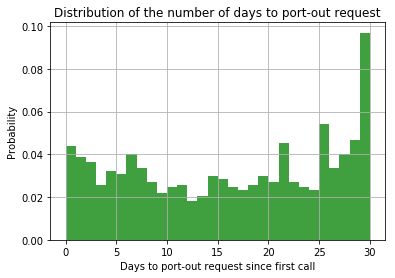

In [74]:
import matplotlib.pyplot as plt 
import numpy as np

days_to_port_np_filt = np.asarray(days_to_port_filt)
# the histogram of the data
n, bins, patches = plt.hist(days_to_port_np_filt,30, density=True,facecolor='g',alpha=0.75)
plt.xlabel('Days to port-out request since first call')
plt.ylabel('Probability')
plt.title('Distribution of the number of days to port-out request')
plt.grid(True)
plt.show()

In [25]:
from pyspark.sql.functions import datediff, unix_timestamp, from_unixtime, translate, substring

df_base_tgs_port_ccc = (df_base_tgs_port_ccc.withColumn("days_from_endcccperiod_to_enddto", when(col("tgs_fecha_fin_dto").isNotNull(),
                                                                     datediff(
                                                                         from_unixtime(unix_timestamp(lit(ccc_end),"yyyyMMdd")),
                                                                         from_unixtime(unix_timestamp("tgs_fecha_fin_dto", "yyyyMMdd"))
                                                                     ).cast("double")).otherwise(None)))


df_base_tgs_port_ccc = (df_base_tgs_port_ccc.withColumn("EOP", when(col("days_from_endcccperiod_to_enddto").isNull(),0)
                                                              .when(col("days_from_endcccperiod_to_enddto")>0, 1).otherwise(0)))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sunburst(nodes, total=np.pi * 2, offset=0, level=0, ax=None):
    ax = ax or plt.subplot(111, projection='polar')

    if level == 0 and len(nodes) == 1:
        label, value, subnodes = nodes[0]
        ax.bar([0], [0.5], [np.pi * 2])
        ax.text(0, 0, label, ha='center', va='center')
        sunburst(subnodes, total=value, level=level + 1, ax=ax)
    elif nodes:
        d = np.pi * 2 / total
        labels = []
        widths = []
        local_offset = offset
        for label, value, subnodes in nodes:
            labels.append(label)
            widths.append(value * d)
            sunburst(subnodes, total=total, offset=local_offset,
                     level=level + 1, ax=ax)
            local_offset += value
        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * len(nodes)
        bottoms = np.zeros(len(nodes)) + level - 0.5
        rects = ax.bar(values, heights, widths, bottoms, linewidth=1,
                       edgecolor='white', align='edge')
        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            rotation = (90 + (360 - np.degrees(x) % 180)) % 360
            ax.text(x, y, label, rotation=rotation, ha='center', va='center') 

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()
    
    fig = plt.gcf()
    fig.set_size_inches(18,12)
    
sunburst(data_ccc_churn) 

In [ ]:
# Libraries
import matplotlib.pyplot as plt
 
# Make data: I have 3 groups and 7 subgroups
group_names=['groupA', 'groupB', 'groupC']
group_size=[12,11,30]
subgroup_names=['A.1', 'A.2', 'A.3', 'B.1', 'B.2', 'C.1', 'C.2', 'C.3', 'C.4', 'C.5']
subgroup_size=[4,3,5,6,5,10,5,5,4,6]
 
# Create colors
a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6), c(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), c(0.6), c(0.5), c(0.4), c(0.3), c(0.2)])
plt.setp( mypie2, width=0.4, edgecolor='white')

plt.margins(0,0)
 
# show it
fig = plt.gcf()
fig.set_size_inches(18,12)
plt.show()

In [26]:
df_model_out = spark.read.load("/data/attributes/vf_es/model_outputs/model_parameters/model_name=churn_preds_onlymob")
df_model_out.show(truncate=False)

+-------------------+-----------+---------------------+------+-------------------------------------------------------------------------------------------+------------+-----------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+------+---------+------------+----------+----+-----+---+
|executed_at        |model_level|training_closing_date|target|model_path                                                                                 |metrics_path|metrics_train                                                                                                                            |metrics_test                                                                                                             |varimp|algorithm|author_login|extra_info|year|month|day|
+-------------------+-----------

In [23]:
df_model_scores = spark.read.load("/data/attributes/vf_es/model_outputs/model_scores/model_name=churn_preds_onlymob")
df_model_scores.show()

+-------------------+-------------------+--------------------+---------+---------+---------+--------------------+--------------------+----------+----------+----+-----+---+
|        executed_at|  model_executed_at|predict_closing_date|   msisdn|client_id|      nif|        model_output|             scoring|prediction|extra_info|year|month|day|
+-------------------+-------------------+--------------------+---------+---------+---------+--------------------+--------------------+----------+----------+----+-----+---+
|2019-02-14 16:57:45|2019-02-14 16:57:45|            20190207|645783469|492979105|20073962U| 0.04239367760097494| 0.04239367760097494|         -|         -|2019|    2| 14|
|2019-02-14 16:57:45|2019-02-14 16:57:45|            20190207|648713198|534831103|87997617U| 0.03519501181008838| 0.03519501181008838|         -|         -|2019|    2| 14|
|2019-02-14 16:57:45|2019-02-14 16:57:45|            20190207|636767456|233910702|51741736A| 0.43516915190087846| 0.43516915190087846|      